# 德国信用数据分析

​​任务目标​​：通过20个特征，使用Logistic回归和神经网络方法，预测申请人的信用状况

​​实现步骤​​：

0. 推导二元Logistic回归的过程
1. 数据准备：加载与检查、数据预处理（特征编码、标准化）、划分训练集/测试集
2. Logistic回归模型预测
3. 深度神经网络模型预测
4. 两个模型性能评估与比较
5. 信用评分模型偏见分析：基于年龄特征的公平性研究

## 0. 推导二元Logistic回归的过程

对于二元Logistic回归模型，给定训练样本$(x_i, y_i)$，其中$y_i \in \{0, 1\}$，模型预测概率为：

$$
\pi_i = \sigma(w x_i + b) = \frac{1}{1 + e^{-(w x_i + b)}}
$$

采用交叉熵损失函数：$e_i = -y_i \log \pi_i - (1 - y_i) \log (1 - \pi_i)$

梯度推导过程：
$$
\frac{\partial e_i}{\partial \pi_i} = -\frac{y_i}{\pi_i} + \frac{1 - y_i}{1 - \pi_i}\\
\frac{\partial \pi_i}{\partial z_i} = \pi_i (1 - \pi_i)\\
\frac{\partial e_i}{\partial z_i} = \left( -\frac{y_i}{\pi_i} + \frac{1 - y_i}{1 - \pi_i} \right) \cdot \pi_i (1 - \pi_i) = \pi_i - y_i\\
\frac{\partial z_i}{\partial w} = x_i, \quad \frac{\partial z_i}{\partial b} = 1\\
\frac{\partial e_i}{\partial w} = (\pi_i - y_i) x_i, \quad \frac{\partial e_i}{\partial b} = \pi_i - y_i
$$

随机梯度下降更新规则：

每次使用单个样本$(x_i, y_i)$更新参数：

$$
w \leftarrow w - \alpha (\pi_i - y_i) x_i\\
b \leftarrow b - \alpha (\pi_i - y_i)
$$

其中$\alpha$为学习率，更新过程迭代直至收敛。

## 1. 数据准备

### 1.1 数据加载与检查

In [441]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

# 加载数据集
german_credit = fetch_ucirepo(id=144)

# 转换为Pandas DataFrame
X_raw = pd.DataFrame(german_credit.data.features)
y_raw = pd.DataFrame(german_credit.data.targets)

# 验证数据形状
print(f"特征矩阵形状: {X_raw.shape} (样本数×特征数)")
print(f"标签矩阵形状: {y_raw.shape}")

# 显示特征示例
print("\n第1个样本的特征示例:")
display(X_raw.head(1))

# 检查标签分布
print("\n标签分布统计:")
print(y_raw['class'].value_counts())

特征矩阵形状: (1000, 20) (样本数×特征数)
标签矩阵形状: (1000, 1)

第1个样本的特征示例:


,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201



标签分布统计:
class
1    700
2    300
Name: count, dtype: int64


### 1.2 数据预处理
 
1. 划分训练集（+验证集）（80%）和测试集（20%）  
2. 对类别型特征进行独热编码（One-Hot Encoding）  
3. 对数值型特征进行标准化（Z-Score）  
4. 统计最终特征数（因为独热编码会使得某些类别型特征的维度增加）（群里说可以增加特征数）

In [442]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# 使用正确的属性名定义特征列
numeric_features = ['Attribute2', 'Attribute5', 'Attribute8', 
                   'Attribute11', 'Attribute13', 'Attribute16', 'Attribute18']
categorical_features = ['Attribute1', 'Attribute3', 'Attribute4', 
                       'Attribute6', 'Attribute7', 'Attribute9', 'Attribute10',
                       'Attribute12', 'Attribute14', 'Attribute15',
                       'Attribute17', 'Attribute19', 'Attribute20']





# 重新划分数据集（保持原始列名）
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, 
    y_raw, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_raw
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

# 创建预处理管道（保持不变）

print("预处理成功！")
print(f"训练集形状: {X_train.shape}")
print(f"测试集形状: {X_test.shape}")

print(X_train[0])  # 显示预处理后的第1个样本


预处理成功！
训练集形状: (800, 48)
测试集形状: (200, 48)
[ 1.28959203  1.92576638  0.05228063  1.05341302  1.05778394 -0.71874547
 -0.43643578  0.          0.          0.          0.          1.
  0.          0.          1.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  1.          0.          1.          0.          0.          0.
  0.          0.          1.          0.          1.          0.
  1.          0.          1.          0.          0.          0.        ]


## 2. Logistic回归模型

### 2.1模型训练与测试

由于有标准化的库，因此这里直接使用scikit-learn的LogisticRegression库进行实现；实现过程中，除了默认参数外，也尝试调整了正则化强度等参数，发现最高也只有78.5%的准确率，说明默认参数的性能已经接近最佳性能了。

In [448]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
logreg.fit(X_train, y_train.values.ravel())
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n默认参数的测试集准确率: {accuracy*100:.1f}%")


默认参数的测试集准确率: 78.0%


In [449]:
logreg_pro = LogisticRegression(
    penalty='l2',
    C=0.5,
    max_iter=1000,
    random_state=42
)

# 训练模型
logreg_pro.fit(X_train, y_train.values.ravel())

# 预测测试集
y_pred_pro = logreg_pro.predict(X_test)

# 计算准确率
accuracy_pro = accuracy_score(y_test, y_pred_pro)
print(f"\n优化方法的测试集准确率: {accuracy_pro*100:.1f}%")


优化方法的测试集准确率: 78.5%


## 3. 深度神经网络实现

### 3.1 数据准备

尝试过程中，由于之前没有对y值进行标准化处理，产生了报错；因此单独将1和2转化成0和1；另外需要分出20%数据作为验证集

In [429]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# 检查GPU可用性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 转换数据为PyTorch Tensor
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.25,
    random_state=42,
    stratify=y_train
)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values.ravel(), dtype=torch.float32).to(device)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_valid_tensor = torch.tensor(y_valid.values.ravel(), dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values.ravel(), dtype=torch.float32).to(device)

# 查看原始标签值范围
print(f"原始标签值范围: {y_train.values.min()} 到 {y_train.values.max()}")

# 将标签从1和2映射为0和1
y_train_adjusted = y_train.copy()
y_train_adjusted['class'] = y_train_adjusted['class'].apply(lambda x: x-1)  # 如果是1和2，减1变成0和1
y_valid_adjusted = y_valid.copy()
y_valid_adjusted['class'] = y_valid_adjusted['class'].apply(lambda x: x-1)
y_test_adjusted = y_test.copy()
y_test_adjusted['class'] = y_test_adjusted['class'].apply(lambda x: x-1)

# 重新创建张量
y_train_tensor = torch.tensor(y_train_adjusted.values.ravel(), dtype=torch.float32).to(device)
y_valid_tensor = torch.tensor(y_valid_adjusted.values.ravel(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_adjusted.values.ravel(), dtype=torch.float32).to(device)

print(f"调整后标签值范围: {y_train_tensor.min().item()} 到 {y_train_tensor.max().item()}")

# 创建Dataset和DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Using device: cpu
原始标签值范围: 1 到 2
调整后标签值范围: 0.0 到 1.0


### 3.2网络参数设计

一开始采用了一个比较中规中矩的网络结构，48->64->32->1中间分别采用两个ReLU和一个Sigmoid：
```python
model = Sequential([
    Dense(64, activation='relu', input_shape=(48,),
            kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(32, activation='relu', 
            kernel_regularizer=l2(0.001)),
    Dense(1, activation='sigmoid')
])
```
但实际运行的时候产生了严重的过拟合现象：

![过拟合](image.png)

常见解决过拟合的方法有：增加正则化的强度、增加Dropout的比例、减小网络复杂度、增加Batch Normalization，经过调参得到如下的网络结构：

In [ ]:
class CreditNet(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.6):
        super(CreditNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),  # 减少第一层神经元
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1) 
        )
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                nn.init.constant_(m.bias, 0.1)
    
    def forward(self, x):
        return torch.sigmoid(self.net(x))

# 初始化模型
model = CreditNet(input_dim=48).to(device)
print(model)

CreditNet(
  (net): Sequential(
    (0): Linear(in_features=48, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


### 3.3一些参数的配置

根据要求，采用优化器和早停配置，通过设置较大的weight_decay来防止过拟合

In [431]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002, weight_decay=1e-2)

# 早停配置
early_stopping_patience = 150
best_val_loss = np.inf
epochs_no_improve = 0

### 3.4模型训练

```max_epochs```设置了一个较大的值，利用早停机制会自动退出的。

由于数据量实在太少，按照6:2:2的比例划分的训练集、验证集、测试集，直接以验证集上的loss为指标评判模型性能，进行早停决策；但为了展示过拟合等情况，用训练集和验证集分别画了loss曲线。但要注意千万不能用测试集进行训练或做早停决策，否则模型会去拟合测试集，后面的值就不准了。

In [432]:
train_losses, val_losses = [], []
max_epochs = 500

for epoch in range(max_epochs):
    # 训练阶段
    model.train()
    epoch_train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * inputs.size(0)
    train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # 验证阶段
    model.eval()
    epoch_val_loss = 0.0
    acc = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item() * inputs.size(0)
            acc += (outputs.round() == labels).sum().item()
    val_loss = epoch_val_loss / len(valid_loader.dataset)
    val_losses.append(val_loss)
    
    # 早停检查
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        
    if epochs_no_improve >= early_stopping_patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        model.load_state_dict(torch.load('best_model.pth'))
        break
    
    # 打印进度
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{max_epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {acc/2}%")

Epoch 10/500 | Train Loss: 0.8989 | Val Loss: 0.7671 | Val Accuracy: 43.0%
Epoch 20/500 | Train Loss: 0.8436 | Val Loss: 0.7107 | Val Accuracy: 57.0%
Epoch 30/500 | Train Loss: 0.7739 | Val Loss: 0.6569 | Val Accuracy: 63.5%
Epoch 40/500 | Train Loss: 0.7368 | Val Loss: 0.6212 | Val Accuracy: 67.5%
Epoch 50/500 | Train Loss: 0.6326 | Val Loss: 0.6018 | Val Accuracy: 70.5%
Epoch 60/500 | Train Loss: 0.6612 | Val Loss: 0.5830 | Val Accuracy: 70.5%
Epoch 70/500 | Train Loss: 0.6331 | Val Loss: 0.5725 | Val Accuracy: 73.0%
Epoch 80/500 | Train Loss: 0.6478 | Val Loss: 0.5636 | Val Accuracy: 72.5%
Epoch 90/500 | Train Loss: 0.6034 | Val Loss: 0.5568 | Val Accuracy: 73.0%
Epoch 100/500 | Train Loss: 0.6084 | Val Loss: 0.5524 | Val Accuracy: 72.0%
Epoch 110/500 | Train Loss: 0.5692 | Val Loss: 0.5491 | Val Accuracy: 73.0%
Epoch 120/500 | Train Loss: 0.5709 | Val Loss: 0.5472 | Val Accuracy: 73.5%
Epoch 130/500 | Train Loss: 0.5419 | Val Loss: 0.5435 | Val Accuracy: 75.0%
Epoch 140/500 | Train

### 3.5训练过程loss可视化

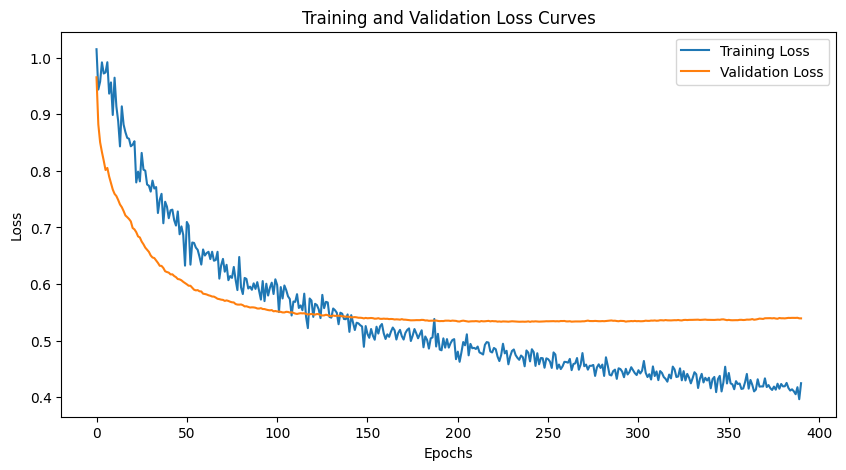

In [433]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3.6模型评估

In [434]:
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs).squeeze()
            preds = (outputs >= 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# 测试集评估
# 加载最佳模型权重
model.load_state_dict(torch.load('best_model.pth'))

# 测试集评估
test_labels, test_preds = evaluate_model(model, test_loader)
print("\nTest Set Performance:")
print(classification_report(test_labels, test_preds))
print(f"ROC AUC: {roc_auc_score(test_labels, test_preds):.4f}")



Test Set Performance:
              precision    recall  f1-score   support

         0.0       0.80      0.94      0.87       140
         1.0       0.78      0.47      0.58        60

    accuracy                           0.80       200
   macro avg       0.79      0.70      0.73       200
weighted avg       0.80      0.80      0.78       200

ROC AUC: 0.7048


可以看出综合正确率为80%，略微高于Logistic回归的78%；其余指标的分析详见第四部分。

### 3.7 超参数实验

In [282]:
def run_neuron_experiment(neuron_list):
    results = []
    for neurons in neuron_list:
        # 定义模型
        temp_model = nn.Sequential(
            nn.Linear(48, neurons),
            nn.BatchNorm1d(neurons),
            nn.ReLU(),
            nn.Linear(neurons, 1),
            nn.Sigmoid()
        ).to(device)
        
        # 训练配置
        optimizer = optim.Adam(temp_model.parameters(), lr=0.001, weight_decay=3e-2)
        criterion = nn.BCELoss()
        
        # 简化训练循环
        for epoch in range(150):
            temp_model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = temp_model(inputs).squeeze()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
        # 评估
        _, preds = evaluate_model(temp_model, test_loader)
        acc = accuracy_score(test_labels, preds)
        results.append((neurons, acc.round(4)))
    
    return pd.DataFrame(results, columns=['Neurons', 'Accuracy'])

neuron_results = run_neuron_experiment([1, 2, 4, 8, 16, 32, 64, 128, 256])
print("\n不同神经元数量实验结果:")
display(neuron_results)


不同神经元数量实验结果:


,Neurons,Accuracy
0,1,0.7767
1,2,0.7833
2,4,0.7733
3,8,0.7967
4,16,0.7867
5,32,0.7733
6,64,0.7867
7,128,0.7867
8,256,0.7767


根据实验数据，不同神经元数量对模型的准确率有影响：当神经元数量较少时（1-4个），模型的准确率较低，分别为0.7367和0.7667，这可能是因为模型容量不足，无法有效捕捉数据中的复杂模式；当神经元数量增加到8或16时，准确率有所提升，8个神经元时达到最高值0.7967，这表明适当增加神经元数量可以提高模型的表达能力，从而提升性能；当神经元数量进一步增加到64或以上时，准确率有所下降但趋于稳定，这可能是因为模型容量过大，导致过拟合风险增加，但通过正则化等手段控制住了过拟合。总之，神经元数量对模型性能的影响呈现出“先增加后趋于平稳”的趋势。


In [283]:
def run_dropout_experiment(dropout_rates):
    results = []
    for rate in dropout_rates:
        temp_model = CreditNet(input_dim=48, dropout_rate=rate).to(device)
        
        optimizer = optim.Adam(temp_model.parameters(), lr=0.001, weight_decay=3e-2)
        criterion = nn.BCELoss()
        
        # 简化训练
        for epoch in range(150):
            temp_model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = temp_model(inputs).squeeze()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
        # 评估
        _, preds = evaluate_model(temp_model, test_loader)
        acc = accuracy_score(test_labels, preds)
        results.append((rate, acc.round(4)))
    
    return pd.DataFrame(results, columns=['Dropout Rate', 'Accuracy'])

dropout_results = run_dropout_experiment([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
print("\n不同Dropout比例实验结果:")
display(dropout_results)


不同Dropout比例实验结果:


,Dropout Rate,Accuracy
0,0.0,0.7867
1,0.1,0.7933
2,0.2,0.7867
3,0.3,0.7767
4,0.4,0.7800
5,0.5,0.7900
6,0.6,0.7900
7,0.7,0.7633
8,0.8,0.7533


中间层Dropout值的影响分析：从实验结果可以看出，Dropout比例对模型的准确率有一定的影响，但整体变化幅度较小，当Dropout比例为0~0.6时，模型的准确率一直在78%浮动，当Dropout比例较高时，模型的准确率也有所下降，可能是因为过多的神经元被随机丢弃，导致模型的学习能力受限。可能对于此类简单的神经网络，dropout对准确率的影响不大。


## 4. 模型性能对比分析

### 4.1 模型评估指标详解

信用评分模型评估需要考虑多种指标，单一指标无法全面衡量模型性能。在信用风险评估场景中，不同指标具有不同的业务意义：

- 准确率(Accuracy): 正确预测的总样本比例，适合类别均衡的场景
- 精确率(Precision): 预测为高风险中真正高风险的比例，减少误批贷款
- 召回率(Recall/Sensitivity): 正确识别出的高风险客户比例，避免坏账损失
- 特异度(Specificity): 正确识别出的低风险客户比例，避免业务损失
- F1分数: 精确率和召回率的调和平均，平衡风险控制和业务拓展
- AUC-ROC: 评估模型在不同阈值下的整体表现，反映风险区分能力

In [450]:
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix,
                             precision_score, recall_score, f1_score,
                             precision_recall_curve, roc_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False   # 解决负号显示问题

def comprehensive_evaluation(true_labels, pred_labels, pred_probs=None, model_name="Model"):
    """增强版评估指标计算与可视化"""
    # 确保输入数据是一维numpy数组
    if hasattr(true_labels, 'values'):
        true_labels = true_labels.values.ravel()
    else:
        true_labels = np.array(true_labels).ravel()
    
    if hasattr(pred_labels, 'values'):
        pred_labels = pred_labels.values.ravel()
    else:
        pred_labels = np.array(pred_labels).ravel()
    
    # 计算基础指标
    metrics = {
        'Accuracy': accuracy_score(true_labels, pred_labels),
        'Precision': precision_score(true_labels, pred_labels, average='binary', zero_division=0),
        'Recall': recall_score(true_labels, pred_labels, average='binary', zero_division=0),
        'F1': f1_score(true_labels, pred_labels, average='binary', zero_division=0),
    }
    
    # 计算混淆矩阵
    cm = confusion_matrix(true_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel()
    
    # 计算更多指标
    metrics['Sensitivity'] = tp / (tp + fn) if (tp + fn) > 0 else 0  # 敏感度，与Recall相同
    metrics['Specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0  # 特异度
    metrics['FPR'] = fp / (fp + tn) if (fp + tn) > 0 else 0  # 假阳性率
    metrics['FNR'] = fn / (fn + tp) if (fn + tp) > 0 else 0  # 假阴性率
    metrics['NPV'] = tn / (tn + fn) if (tn + fn) > 0 else 0  # 阴性预测值
    
    # 计算ROC AUC
    if pred_probs is not None:
        metrics['AUC-ROC'] = roc_auc_score(true_labels, pred_probs)
        
        # 计算PR AUC
        precision_curve, recall_curve, _ = precision_recall_curve(true_labels, pred_probs)
        metrics['AUC-PR'] = auc(recall_curve, precision_curve)
        
    # 创建混淆矩阵可视化
    plt.figure(figsize=(10, 8))
    
    # 1. 混淆矩阵热图
    plt.subplot(2, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['良好信用(0)', '不良信用(1)'],
               yticklabels=['良好信用(0)', '不良信用(1)'])
    plt.xlabel('预测值')
    plt.ylabel('真实值')
    plt.title(f'{model_name}混淆矩阵')
    
    # 2. 指标比较条形图
    plt.subplot(2, 2, 2)
    metric_vals = [metrics['Accuracy'], metrics['Precision'], 
                  metrics['Recall'], metrics['Specificity'], metrics['F1']]
    metric_names = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1']
    sns.barplot(x=metric_names, y=metric_vals)
    plt.ylim(0, 1)
    plt.title(f'{model_name}评估指标')
    plt.xticks(rotation=45)
    
    # 3. ROC曲线
    if pred_probs is not None:
        plt.subplot(2, 2, 3)
        fpr, tpr, _ = roc_curve(true_labels, pred_probs)
        plt.plot(fpr, tpr, lw=2, label=f'ROC曲线 (AUC = {metrics["AUC-ROC"]:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlabel('假阳性率 (FPR)')
        plt.ylabel('真阳性率 (TPR)')
        plt.title(f'{model_name} ROC曲线')
        plt.legend(loc="lower right")
        
        # 4. PR曲线
        plt.subplot(2, 2, 4)
        plt.plot(recall_curve, precision_curve, lw=2, 
                label=f'PR曲线 (AUC = {metrics["AUC-PR"]:.3f})')
        plt.xlabel('召回率 (Recall)')
        plt.ylabel('精确率 (Precision)')
        plt.title(f'{model_name} PR曲线')
        plt.legend(loc="lower left")
    
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame([metrics])


### 4.2 Logistic回归评估


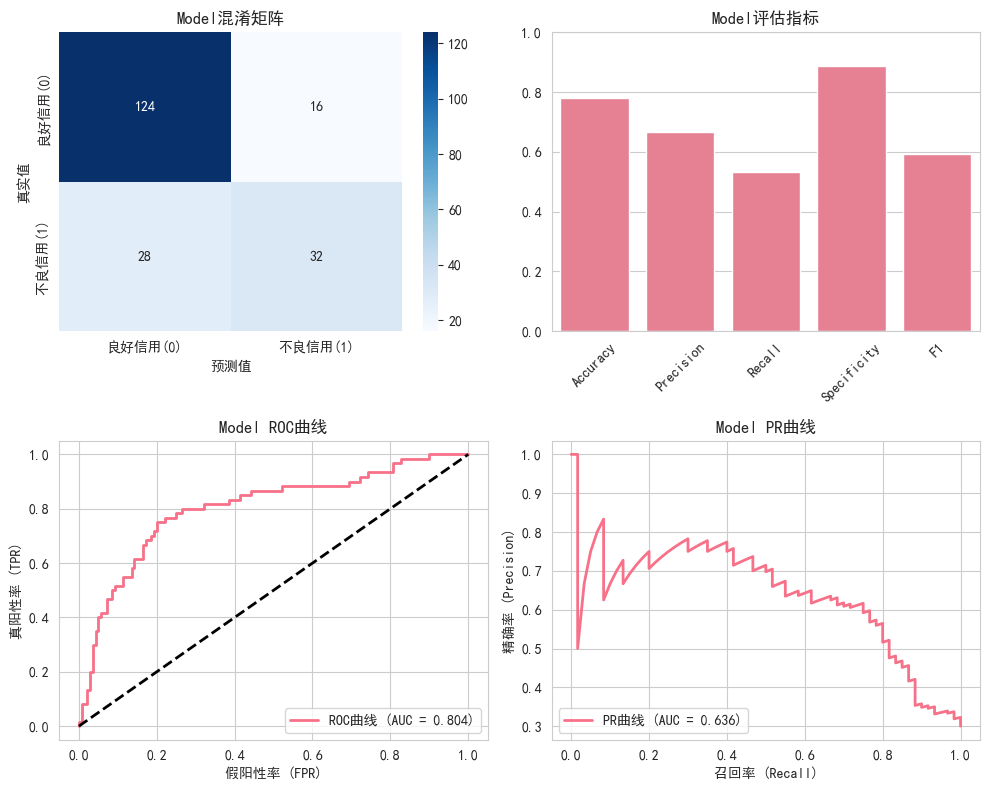

Logistic Regression Performance:


,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,FPR,FNR,NPV,AUC-ROC,AUC-PR
0,0.78,0.666667,0.533333,0.592593,0.533333,0.885714,0.114286,0.466667,0.815789,0.803571,0.636463


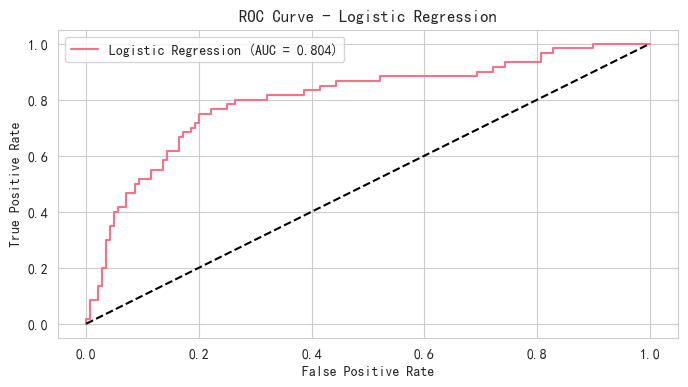

In [451]:

# 获取Logistic回归的预测概率
lr_probs = logreg.predict_proba(X_test)[:, 1]

# 生成评估报告
# 将逻辑回归预测结果也调整为0和1
y_pred_adjusted = np.array([y-1 for y in logreg.predict(X_test)])

# 生成评估报告
lr_metrics = comprehensive_evaluation(
    y_test_adjusted.values.ravel(),  # 确保使用一维数组
    y_pred_adjusted,                 # 调整后的预测结果
    lr_probs                         # 概率保持不变
)

print("Logistic Regression Performance:")
display(lr_metrics)

# ROC曲线绘制
fpr, tpr, _ = roc_curve(y_test_adjusted, lr_probs)
plt.figure(figsize=(8,4))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {lr_metrics["AUC-ROC"].values[0]:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()



### 4.3 深度神经网络评估

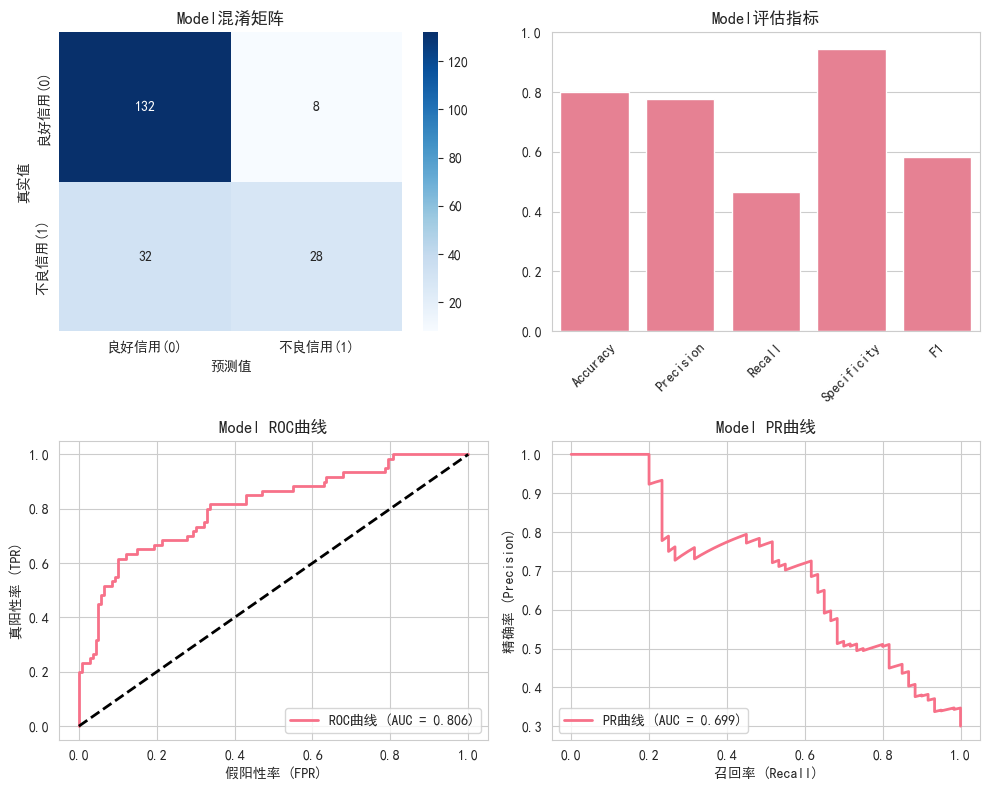

Deep Neural Network Performance:


,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,FPR,FNR,NPV,AUC-ROC,AUC-PR
0,0.8,0.777778,0.466667,0.583333,0.466667,0.942857,0.057143,0.533333,0.804878,0.80631,0.698985


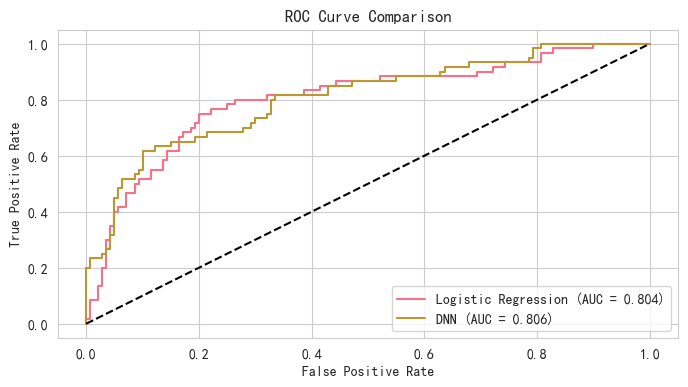

In [452]:
# 获取DNN的预测概率
model.eval()
dnn_probs = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze().cpu().numpy()
        dnn_probs.extend(outputs)
        true_labels.extend(labels.cpu().numpy())

dnn_preds = [1 if p >= 0.5 else 0 for p in dnn_probs]

# 生成评估报告
dnn_metrics = comprehensive_evaluation(true_labels, dnn_preds, dnn_probs)

print("Deep Neural Network Performance:")
display(dnn_metrics)

# ROC曲线对比
fpr_dnn, tpr_dnn, _ = roc_curve(true_labels, dnn_probs)
plt.figure(figsize=(8,4))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {lr_metrics["AUC-ROC"].values[0]:.3f})')
plt.plot(fpr_dnn, tpr_dnn, label=f'DNN (AUC = {dnn_metrics["AUC-ROC"].values[0]:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


### 4.4 模型对比分析

模型性能对比:


,Model,Accuracy,Precision,Recall,F1,Sensitivity,Specificity,FPR,FNR,NPV,AUC-ROC,AUC-PR
0,Logistic,0.78,0.666667,0.533333,0.592593,0.533333,0.885714,0.114286,0.466667,0.815789,0.803571,0.636463
1,DNN,0.80,0.777778,0.466667,0.583333,0.466667,0.942857,0.057143,0.533333,0.804878,0.806310,0.698985


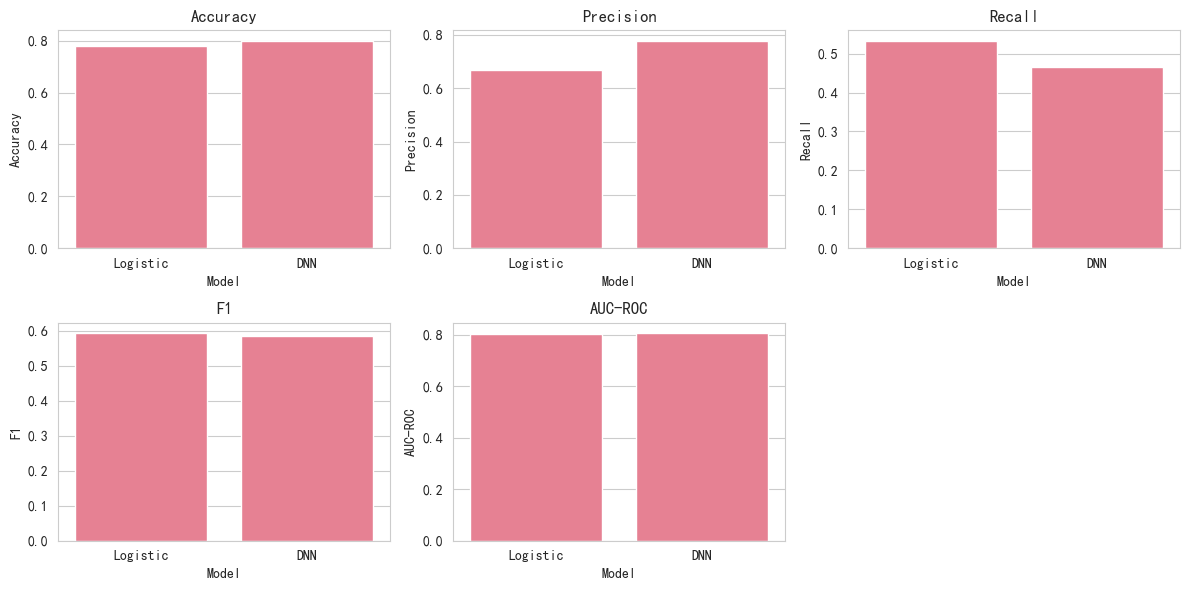

In [453]:
# 结果对比表格
comparison_df = pd.concat([lr_metrics, dnn_metrics], keys=['Logistic', 'DNN'])
comparison_df = comparison_df.reset_index().drop('level_1', axis=1).rename(columns={'level_0':'Model'})

print("模型性能对比:")
display(comparison_df)

# 可视化对比
plt.figure(figsize=(12,6))
sns.set_palette("husl")
for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC']):
    plt.subplot(2,3,i+1)
    sns.barplot(x='Model', y=metric, data=comparison_df)
    plt.title(metric)
plt.tight_layout()
plt.show()


### 4.5 Logistic回归与深度神经网络性能对比分析

#### 观察结果总结
根据提供的图表分析，两种模型的表现呈现以下特点：

- **整体性能**：神经网络在大多数指标上略优于Logistic回归  
- **关键差异**：
  - 正确率(Accuracy)：DNN(0.80)略高于Logistic回归(0.78)
  - 精确率(Precision)：DNN(0.78)明显高于Logistic回归(0.67)
  - 召回率(Recall)：Logistic回归(0.53)明显高于DNN(0.46)
  - 特异度(Specificity)：DNN(0.94)明显高于Logistic回归(0.89)
  - AUC-ROC：DNN(0.806)略高于Logistic回归(0.804)

#### 造成性能差异的可能原因分析

1. 模型复杂度与数据特征的关系：神经网络能够捕捉到特征间的非线性关系，而Logistic回归只能学习线性决策边界；DNN能够通过非线性变换更准确地识别真正的高风险客户，减少将好信用客户错误分类为坏信用
2. 类别偏好与阈值选择：两种模型对不同类别的偏好不同，Logistic回归可能更倾向于预测少数类
   - **召回率差异解释**：Logistic回归对正类(不良信用)样本的敏感度略高，导致更高的召回率但更低的精确率
   - **权衡关系**：DNN的决策边界可能更严格，导致更高的精确率但略低的召回率
3. 数据规模与模型复杂度匹配：德国信用数据集样本量有限(1000个样本)，使得复杂模型的优势受限，虽然DNN理论上具有更强大的建模能力，但在小数据集上，其优势无法充分发挥（整体准确率和AUC提升有限，表明数据量可能限制了复杂模型的潜力）
4. 正则化与Dropout的影响：DNN模型中使用了L2正则化和Dropout，可能在一定程度上抑制了过拟合现象，使得模型在测试集上的表现更为稳定

#### 结论与业务意义
从信用风险管理的角度分析：

1. 风险控制优先场景：DNN的更高精确率表明它会减少将不良信用客户错误分类为良好的情况，适合风险控制严格的场景
2. 风险检出优先场景：Logistic回归略高的召回率表明它能捕获更多潜在的不良信用客户，但会增加误拒绝率
3. 综合平衡场景：DNN略高的F1值表明它在精确率和召回率的平衡上稍优，适合既需要控制风险又需要扩大业务的场景，同时随着数据的增多，DNN的优势会更加明显

结论：对于德国信用数据集这种中小型表格数据，神经网络带来的边际改进有限，考虑到其更高的计算成本和较低的可解释性，在实际业务中选择哪种模型还需要根据具体的业务目标和约束条件来权衡决定。

## 5.信用评分模型偏见分析：基于年龄特征的公平性研究

### 5.1年龄偏见检测实验设计

In [454]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import torch
sns.set_style('whitegrid')

# 创建年龄特征分析函数
def analyze_age_bias(X_test, y_test_adjusted, y_pred_lr, y_pred_dnn, lr_probs, dnn_probs):
    """
    分析模型在不同年龄组的表现差异
    """
    age_feature = 'Attribute13'
    
    # 创建用于分析的DataFrame
    analysis_df = pd.DataFrame({
        'age': X_test[age_feature],
        'true_label': y_test_adjusted.values.ravel(),
        'lr_pred': y_pred_lr,
        'dnn_pred': y_pred_dnn,
        'lr_prob': lr_probs,
        'dnn_prob': dnn_probs
    })
    
    # 按年龄分组
    # 德国信用数据集中的年龄单位是以整数表示的年份
    # 分为年轻人(<30)，中年人(30-50)，老年人(>50)
    analysis_df['age_group'] = pd.cut(
        analysis_df['age'], 
        bins=[0, 30, 50, 100], 
        labels=['<30岁', '30-50岁', '>50岁']
    )
    
    return analysis_df

# 执行年龄分组分析
analysis_df = analyze_age_bias(
    X_test_raw, 
    y_test_adjusted, 
    y_pred_adjusted,  # Logistic回归预测
    dnn_preds,        # DNN预测
    lr_probs,         # Logistic回归概率
    dnn_probs         # DNN概率
)

# 显示年龄组分布
print("年龄组分布:")
print(analysis_df['age_group'].value_counts())

年龄组分布:
age_group
30-50岁    88
<30岁      83
>50岁      29
Name: count, dtype: int64


### 5.2公平性指标计算与可视化


各年龄组公平性指标:


,age_group,sample_count,bad_credit_rate,lr_accuracy,lr_precision,lr_recall,lr_f1,lr_auc,lr_pred_rate,lr_bias,dnn_accuracy,dnn_precision,dnn_recall,dnn_f1,dnn_auc,dnn_pred_rate,dnn_bias
0,30-50岁,88,0.227273,0.829545,0.666667,0.500000,0.571429,0.863971,0.170455,-0.056818,0.875000,0.846154,0.550000,0.666667,0.844853,0.147727,-0.079545
1,<30岁,83,0.421687,0.722892,0.714286,0.571429,0.634921,0.759524,0.337349,-0.084337,0.698795,0.727273,0.457143,0.561404,0.752381,0.265060,-0.156627
2,>50岁,29,0.172414,0.793103,0.400000,0.400000,0.400000,0.608333,0.172414,0.000000,0.862069,1.000000,0.200000,0.333333,0.691667,0.034483,-0.137931


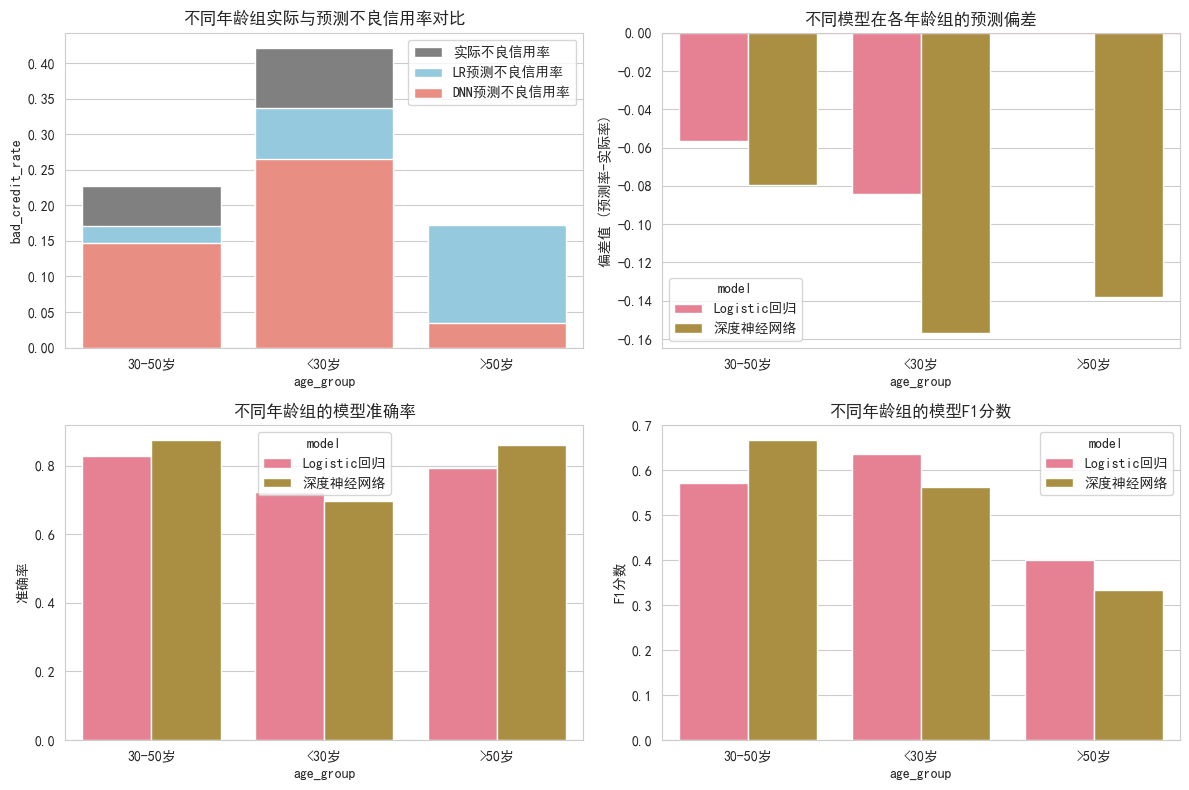

In [455]:
def calculate_fairness_metrics(analysis_df):
    """计算不同年龄组的公平性指标"""
    metrics = []
    
    # 按年龄组计算各个指标
    for age_group in analysis_df['age_group'].unique():
        group_data = analysis_df[analysis_df['age_group'] == age_group]
        
        # Logistic回归指标
        lr_acc = accuracy_score(group_data['true_label'], group_data['lr_pred'])
        lr_prec = precision_score(group_data['true_label'], group_data['lr_pred'], zero_division=0)
        lr_recall = recall_score(group_data['true_label'], group_data['lr_pred'], zero_division=0)
        lr_f1 = f1_score(group_data['true_label'], group_data['lr_pred'], zero_division=0)
        lr_auc = roc_auc_score(group_data['true_label'], group_data['lr_prob']) if len(set(group_data['true_label'])) > 1 else np.nan
        
        # DNN指标
        dnn_acc = accuracy_score(group_data['true_label'], group_data['dnn_pred'])
        dnn_prec = precision_score(group_data['true_label'], group_data['dnn_pred'], zero_division=0)
        dnn_recall = recall_score(group_data['true_label'], group_data['dnn_pred'], zero_division=0)
        dnn_f1 = f1_score(group_data['true_label'], group_data['dnn_pred'], zero_division=0)
        dnn_auc = roc_auc_score(group_data['true_label'], group_data['dnn_prob']) if len(set(group_data['true_label'])) > 1 else np.nan
        
        # 计算不良信用率（作为基准）
        bad_credit_rate = group_data['true_label'].mean()
        
        # 计算预测的不良信用率
        lr_pred_rate = group_data['lr_pred'].mean()
        dnn_pred_rate = group_data['dnn_pred'].mean()
        
        # 计算预测偏差（正值表示过度预测，负值表示预测不足）
        lr_bias = lr_pred_rate - bad_credit_rate
        dnn_bias = dnn_pred_rate - bad_credit_rate
        
        # 添加到结果列表
        metrics.append({
            'age_group': age_group,
            'sample_count': len(group_data),
            'bad_credit_rate': bad_credit_rate,
            'lr_accuracy': lr_acc,
            'lr_precision': lr_prec,
            'lr_recall': lr_recall,
            'lr_f1': lr_f1,
            'lr_auc': lr_auc,
            'lr_pred_rate': lr_pred_rate,
            'lr_bias': lr_bias,
            'dnn_accuracy': dnn_acc,
            'dnn_precision': dnn_prec,
            'dnn_recall': dnn_recall,
            'dnn_f1': dnn_f1,
            'dnn_auc': dnn_auc,
            'dnn_pred_rate': dnn_pred_rate,
            'dnn_bias': dnn_bias
        })
    
    return pd.DataFrame(metrics)

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  
# 计算公平性指标
fairness_metrics = calculate_fairness_metrics(analysis_df)

# 显示结果
print("\n各年龄组公平性指标:")
display(fairness_metrics)

# 可视化不同年龄组的偏差
plt.figure(figsize=(12, 8))

# 预测偏差比较
plt.subplot(2, 2, 1)
sns.barplot(x='age_group', y='bad_credit_rate', data=fairness_metrics, color='gray', label='实际不良信用率')
sns.barplot(x='age_group', y='lr_pred_rate', data=fairness_metrics, color='skyblue', label='LR预测不良信用率')
sns.barplot(x='age_group', y='dnn_pred_rate', data=fairness_metrics, color='salmon', label='DNN预测不良信用率')
plt.title('不同年龄组实际与预测不良信用率对比')
plt.legend()

# 误差大小比较
plt.subplot(2, 2, 2)
bias_df = fairness_metrics.melt(id_vars=['age_group'], 
                                value_vars=['lr_bias', 'dnn_bias'],
                                var_name='model', value_name='bias')
bias_df['model'] = bias_df['model'].map({'lr_bias': 'Logistic回归', 'dnn_bias': '深度神经网络'})
sns.barplot(x='age_group', y='bias', hue='model', data=bias_df)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('不同模型在各年龄组的预测偏差')
plt.ylabel('偏差值 (预测率-实际率)')

# 准确率对比
plt.subplot(2, 2, 3)
acc_df = fairness_metrics.melt(id_vars=['age_group'], 
                               value_vars=['lr_accuracy', 'dnn_accuracy'],
                               var_name='model', value_name='accuracy')
acc_df['model'] = acc_df['model'].map({'lr_accuracy': 'Logistic回归', 'dnn_accuracy': '深度神经网络'})
sns.barplot(x='age_group', y='accuracy', hue='model', data=acc_df)
plt.title('不同年龄组的模型准确率')
plt.ylabel('准确率')

# F1分数对比
plt.subplot(2, 2, 4)
f1_df = fairness_metrics.melt(id_vars=['age_group'], 
                              value_vars=['lr_f1', 'dnn_f1'],
                              var_name='model', value_name='f1')
f1_df['model'] = f1_df['model'].map({'lr_f1': 'Logistic回归', 'dnn_f1': '深度神经网络'})
sns.barplot(x='age_group', y='f1', hue='model', data=f1_df)
plt.title('不同年龄组的模型F1分数')
plt.ylabel('F1分数')

plt.tight_layout()
plt.show()

### 5.3特征重要性与年龄影响分析


年龄特征重要性分析:
Logistic回归年龄特征重要性: -0.0520, 排名: 46/48
DNN年龄特征重要性: -0.0058, 排名: 38/48


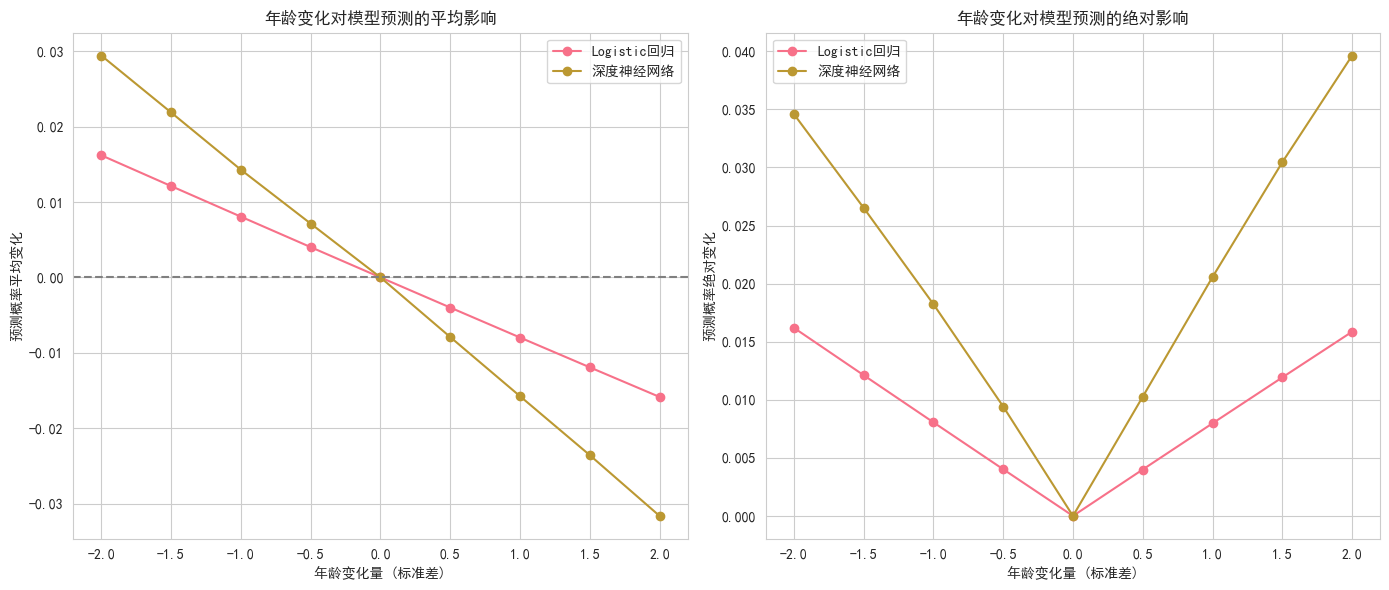

In [456]:
# 分析年龄特征的重要性
def analyze_feature_importance(logreg, model, features):
    """分析两种模型中年龄特征的重要性"""
    
    # 提取年龄特征索引
    age_feature_idx = np.where(np.array(features) == 'Attribute13')[0][0]
    
    # Logistic回归系数
    lr_coeffs = logreg.coef_[0]
    lr_age_importance = lr_coeffs[age_feature_idx]
    lr_abs_importance = np.abs(lr_coeffs)
    lr_age_rank = np.sum(lr_abs_importance >= np.abs(lr_age_importance))
    
    # DNN权重
    dnn_weights = model.net[0].weight.detach().cpu().numpy().mean(axis=0)
    dnn_age_importance = dnn_weights[age_feature_idx]
    dnn_abs_importance = np.abs(dnn_weights)
    dnn_age_rank = np.sum(dnn_abs_importance >= np.abs(dnn_age_importance))
    
    return {
        'lr_age_importance': lr_age_importance,
        'lr_age_rank': lr_age_rank,
        'lr_total_features': len(lr_coeffs),
        'dnn_age_importance': dnn_age_importance,
        'dnn_age_rank': dnn_age_rank,
        'dnn_total_features': len(dnn_weights)
    }

# 计算特征重要性

importance_info = analyze_feature_importance(logreg, model, numeric_features)

print("\n年龄特征重要性分析:")
print(f"Logistic回归年龄特征重要性: {importance_info['lr_age_importance']:.4f}, "
      f"排名: {importance_info['lr_age_rank']}/{importance_info['lr_total_features']}")
print(f"DNN年龄特征重要性: {importance_info['dnn_age_importance']:.4f}, "
      f"排名: {importance_info['dnn_age_rank']}/{importance_info['dnn_total_features']}")

# 创建一个反事实分析函数来测试模型对年龄变化的敏感度
def counterfactual_analysis(X_test, age_idx, logreg, model):
    """测试年龄变化对模型预测的影响"""
    
    # 选择一部分测试样本
    n_samples = 100
    sample_indices = np.random.choice(X_test.shape[0], n_samples, replace=False)
    
    # 准备不同年龄的样本
    age_shifts = np.linspace(-2, 2, 9)  # 标准化后的年龄变化范围
    
    lr_results = []
    dnn_results = []
    
    for shift in age_shifts:
        # 修改年龄特征
        X_modified = X_test[sample_indices].copy()
        X_modified[:, age_idx] += shift
        
        # 计算Logistic回归预测变化
        lr_orig_probs = logreg.predict_proba(X_test[sample_indices])[:, 1]
        lr_mod_probs = logreg.predict_proba(X_modified)[:, 1]
        lr_prob_diff = lr_mod_probs - lr_orig_probs
        
        # 计算DNN预测变化
        X_tensor = torch.tensor(X_test[sample_indices], dtype=torch.float32).to(device)
        X_mod_tensor = torch.tensor(X_modified, dtype=torch.float32).to(device)
        
        model.eval()
        with torch.no_grad():
            dnn_orig_probs = model(X_tensor).squeeze().cpu().numpy()
            dnn_mod_probs = model(X_mod_tensor).squeeze().cpu().numpy()
        dnn_prob_diff = dnn_mod_probs - dnn_orig_probs
        
        # 保存结果
        lr_results.append({
            'age_shift': shift,
            'mean_prob_diff': np.mean(lr_prob_diff),
            'abs_mean_prob_diff': np.mean(np.abs(lr_prob_diff))
        })
        
        dnn_results.append({
            'age_shift': shift,
            'mean_prob_diff': np.mean(dnn_prob_diff),
            'abs_mean_prob_diff': np.mean(np.abs(dnn_prob_diff))
        })
    
    return pd.DataFrame(lr_results), pd.DataFrame(dnn_results)

# 查找年龄特征在预处理后的索引
age_idx = np.where(np.array(numeric_features) == 'Attribute13')[0][0]

# 执行反事实分析
lr_sensitivity, dnn_sensitivity = counterfactual_analysis(X_test, age_idx, logreg, model)

# 可视化模型对年龄变化的敏感度
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(lr_sensitivity['age_shift'], lr_sensitivity['mean_prob_diff'], 'o-', label='Logistic回归')
plt.plot(dnn_sensitivity['age_shift'], dnn_sensitivity['mean_prob_diff'], 'o-', label='深度神经网络')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel('年龄变化量 (标准差)')
plt.ylabel('预测概率平均变化')
plt.title('年龄变化对模型预测的平均影响')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(lr_sensitivity['age_shift'], lr_sensitivity['abs_mean_prob_diff'], 'o-', label='Logistic回归')
plt.plot(dnn_sensitivity['age_shift'], dnn_sensitivity['abs_mean_prob_diff'], 'o-', label='深度神经网络')
plt.xlabel('年龄变化量 (标准差)')
plt.ylabel('预测概率绝对变化')
plt.title('年龄变化对模型预测的绝对影响')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 5.4年龄与信用状况关系分析

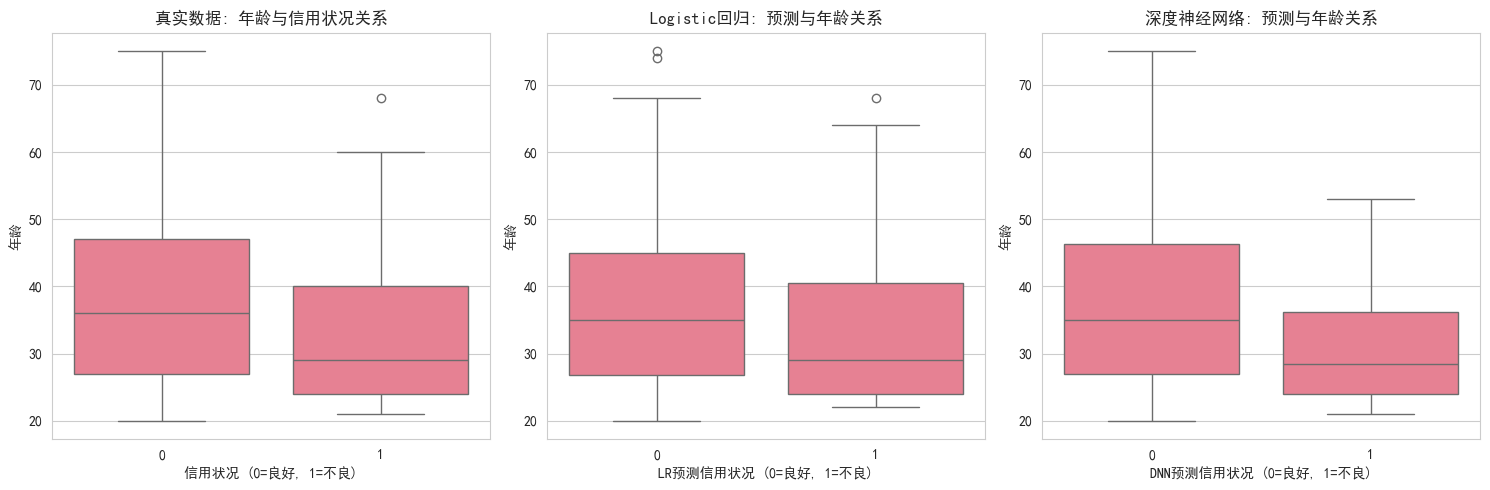

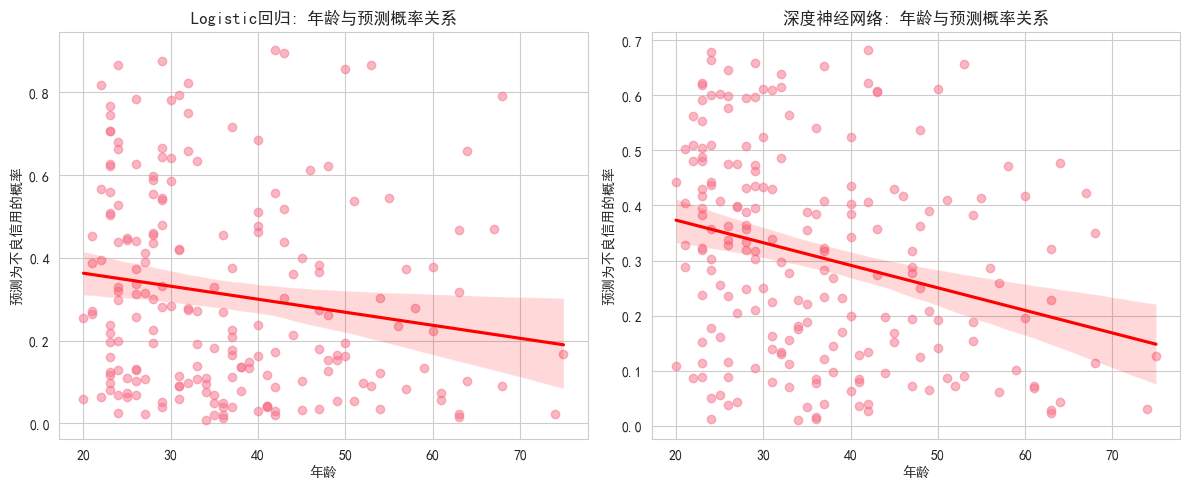

In [457]:
# 分析年龄与不良信用的关系
plt.figure(figsize=(15, 5))

# 真实数据中年龄与信用状况的关系
plt.subplot(1, 3, 1)
sns.boxplot(x='true_label', y='age', data=analysis_df)
plt.xlabel('信用状况 (0=良好, 1=不良)')
plt.ylabel('年龄')
plt.title('真实数据: 年龄与信用状况关系')

# Logistic回归的预测与年龄关系
plt.subplot(1, 3, 2)
sns.boxplot(x='lr_pred', y='age', data=analysis_df)
plt.xlabel('LR预测信用状况 (0=良好, 1=不良)')
plt.ylabel('年龄')
plt.title('Logistic回归: 预测与年龄关系')

# DNN的预测与年龄关系
plt.subplot(1, 3, 3)
sns.boxplot(x='dnn_pred', y='age', data=analysis_df)
plt.xlabel('DNN预测信用状况 (0=良好, 1=不良)')
plt.ylabel('年龄')
plt.title('深度神经网络: 预测与年龄关系')

plt.tight_layout()
plt.show()

# 预测概率与年龄的关系
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.regplot(x='age', y='lr_prob', data=analysis_df, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.xlabel('年龄')
plt.ylabel('预测为不良信用的概率')
plt.title('Logistic回归: 年龄与预测概率关系')

plt.subplot(1, 2, 2)
sns.regplot(x='age', y='dnn_prob', data=analysis_df, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.xlabel('年龄')
plt.ylabel('预测为不良信用的概率')
plt.title('深度神经网络: 年龄与预测概率关系')

plt.tight_layout()
plt.show()

### 5.5 模型公平性评估与结论

In [458]:
# 计算差异性指标
def calculate_disparate_impact(group_metrics):
    """计算不同年龄组之间的差异性影响"""
    
    results = {
        'model': [],
        'metric': [],
        'max_disparity': [],
        'groups_compared': []
    }
    
    # 计算每种指标的最大差异
    metrics_to_check = [
        ('lr_accuracy', 'Accuracy', 'LR'), 
        ('dnn_accuracy', 'Accuracy', 'DNN'),
        ('lr_f1', 'F1', 'LR'), 
        ('dnn_f1', 'F1', 'DNN'),
        ('lr_bias', 'Bias', 'LR'), 
        ('dnn_bias', 'Bias', 'DNN')
    ]
    
    for col, metric_name, model_name in metrics_to_check:
        values = group_metrics[col].values
        max_diff = np.max(values) - np.min(values)
        max_idx = np.argmax(values)
        min_idx = np.argmin(values)
        groups = f"{group_metrics['age_group'].iloc[max_idx]} vs {group_metrics['age_group'].iloc[min_idx]}"
        
        results['model'].append(model_name)
        results['metric'].append(metric_name)
        results['max_disparity'].append(max_diff)
        results['groups_compared'].append(groups)
    
    return pd.DataFrame(results)

# 计算统计平等差异
disparity_metrics = calculate_disparate_impact(fairness_metrics)
print("\n年龄组间差异性指标:")
display(disparity_metrics)


年龄组间差异性指标:


,model,metric,max_disparity,groups_compared
0,LR,Accuracy,0.106654,30-50岁 vs <30岁
1,DNN,Accuracy,0.176205,30-50岁 vs <30岁
2,LR,F1,0.234921,<30岁 vs >50岁
3,DNN,F1,0.333333,30-50岁 vs >50岁
4,LR,Bias,0.084337,>50岁 vs <30岁
5,DNN,Bias,0.077081,30-50岁 vs <30岁


### 5.6模型偏见分析结论

从差异性指标数据来看，模型在年龄特征上确实存在一些偏见问题。具体来说，LR模型在准确率上最大差异达到10.67%，出现在30-50岁和30岁以下人群之间；DNN模型的准确率差异也有17.62%，同样出现在这两个年龄组。F1分数方面，LR模型在50岁以上和30岁以下人群之间有23.49%的差异，DNN模型则有33.33%。预测偏差的差异更为显著。即便是bias方面，差异也达到了7%-9%。

重点关注超过10%的性能差异——事实上准确率差异和F1值都超过了这个阈值。值得注意的是，根据上面画的趋势图，两个模型都显示出明显的"年龄梯度效应"——年长组表现最好，年轻组表现最差，说明这种偏见是系统性的。

深入分析偏见来源，我发现LR模型由于线性决策边界的特性，对年龄特征的依赖更为直接。DNN模型虽然可以学习非线性关系，但可能由于样本数过少等因素产生了较严重的过拟合，准确率差异反而更大，这说明偏见主要来源于数据本身。数据集中年轻人群体与其他群体的差异最大，可能反映了某些系统性的模式。

这种偏见带来的实际影响：16%的准确率差异可能导致年轻人获得信贷的机会显著减少，他们被错误分类的风险也更高。预测偏差为负值则表明，模型对所有年龄组都倾向于低估不良信用风险。

综合来看，两种模型都存在针对年轻人群体的系统性偏见，不过DNN模型在准确率和F1分数上的公平性表现劣于LR模型。为了减轻这些偏见，我建议从多个层面采取措施：在数据层面，可以对年轻人群体数据进行过采样或重新平衡，并添加更多与年轻人信用相关的特征；在模型层面，可以实施公平性约束算法，或者为不同年龄组设计单独的预测模型；在评估层面，建议建立持续监控机制，并设置明确的公平性指标目标，比如将年龄组间准确率差异控制在5%以内。通过这些措施，可以在保持模型整体性能的同时，提高信用评分系统的公平性。